In [1]:
# %load train_test
import os
import numpy as np
import tensorflow as tf
import math
from inputs import get_filename_list, dataset_inputs, get_all_test_data
from evaluation import Normal_Loss, cal_loss, per_class_acc, get_hist, print_hist_summery, train_op
from inference import segnet_vgg, segnet_scratch, segnet_bayes_scratch, segnet_bayes_vgg
import scipy
from scipy import misc
import json

with open("config.json") as f:
    config = json.load(f)

NUM_CLASS = 12 
def Test(test_type):
    batch_size = 1
    #train_dir = "/zhome/1c/2/114196/Documents/SegNet-tensorflow/model.ckpt-4000"
    #test_dir = "/zhome/1c/2/114196/Documents/SegNet/CamVid/test.txt"
    train_dir = "./segnet_scratch/segnet_scratch_30000/model.ckpt-30000"
    test_dir = "./SegNet/CamVid/test.txt"
    image_w = 480
    image_h = 360
    image_c = 3
    FLAG_INFER = "segnet_scratch"
    
    image_filename, label_filename = get_filename_list(test_dir)
    test_data_tensor = tf.placeholder(tf.float32, shape = [batch_size, image_h, image_w, image_c])
    test_label_tensor = tf.placeholder(tf.int64, shape = [batch_size, image_h,image_w,1])
    phase_train = tf.placeholder(tf.bool, name = 'phase_train')
    keep_prob = tf.placeholder(tf.float32,shape = None, name = 'keep_probability')
    if (FLAG_INFER == "segnet_scratch"):
        logits = segnet_scratch(test_data_tensor,test_label_tensor,batch_size,phase_train,keep_prob)
        FLAG_BAYES = False
    elif (FLAG_INFER == "segnet_vgg"):
        logits = segnet_vgg(test_data_tensor,test_label_tensor,batch_size,phase_train,keep_prob)
        FLAG_BAYES = False
    elif (FLAG_INFER == "segnet_bayes_scratch"):
        logits = segnet_bayes_scratch(test_data_tensor,test_label_tensor,batch_size,phase_train,keep_prob)
        FLAG_BAYES = True
    elif (FLAG_INFER == "segnet_bayes_vgg"):
        logits = segnet_bayes_vgg(test_data_tensor, test_label_tensor, batch_size,phase_train,keep_prob)
        FLAG_BAYES = True
    else:
        print("The model is not there YET")
            
    loss, accuracy,prediction = Normal_Loss(logits,test_label_tensor,NUM_CLASS)
    prob = tf.nn.softmax(logits,dim = -1)
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        saver.restore(sess, train_dir)
        hist = np.zeros((NUM_CLASS,NUM_CLASS))
        #images = np.load("/zhome/1c/2/114196/Documents/SegNet-tensorflow/test_image.npy")
        #labels = np.load("/zhome/1c/2/114196/Documents/SegNet-tensorflow/test_label.npy")
        
        if (test_type=='Train'):
            test_type_path = config["TRAIN_FILE"]
            indexes = [0,75,150,225,300]
        elif (test_type=='Validation'):
            test_type_path = config["VAL_FILE"]
            indexes = [0,25,50,75,100]
        elif (test_type=='Test'):
            test_type_path = "SegNet/CamVid/test.txt"
            indexes = [0,50,100,150,200]
            
        image_filename,label_filename = get_filename_list(test_type_path)
        images, labels = get_all_test_data(image_filename,label_filename)
        
        # Subset
        images = [images[i] for i in range(len(images)) if i in indexes]
        labels = [labels[i] for i in range(len(labels)) if i in indexes]
        
        loss_tot = []
        acc_tot = []
        pred_tot = []
        var_tot = []
        step = 0
        #num_images = 1
        for image_batch, label_batch in zip(images,labels):
            image_batch = np.reshape(image_batch,[1,image_h,image_w,image_c])
            label_batch = np.reshape(label_batch,[1,image_h,image_w,1])
            feed_dict = {test_data_tensor: image_batch, test_label_tensor:label_batch, phase_train: False, keep_prob:0.5}
            fetches = [loss, accuracy, logits, prediction]
            if FLAG_BAYES is False:
                loss_per, acc_per,logit,pred = sess.run(fetches = fetches, feed_dict = feed_dict)
                var_one = []
            else:
                logit_iter_tot = []
                loss_iter_tot = []
                acc_iter_tot = []
                prob_iter_tot = []
                for iter_step in range(30):
                    loss_iter_step, acc_iter_step, logit_iter_step,prob_iter_step = sess.run(fetches = [loss,accuracy,logits,prob], feed_dict = feed_dict)
                    loss_iter_tot.append(loss_iter_step)                    
                    acc_iter_tot.append(acc_iter_step)                    
                    logit_iter_tot.append(logit_iter_step)
                    prob_iter_tot.append(prob_iter_step)
                    
                loss_per = np.nanmean(loss_iter_tot)
                acc_per = np.nanmean(acc_iter_tot)
                logit = np.mean(logit_iter_tot,axis = 0)
                prob_mean = np.nanmean(prob_iter_tot)[0]
                prob_variance = np.var(prob_iter_tot, axis = 0)[0]
                #THIS TIME I DIDN'T INCLUDE TAU
                pred = np.reshape(np.argmax(prob_mean,axis = -1),[-1]) #pred is the predicted label
                
                var_sep = [] #var_sep is the corresponding variance if this pixel choose label k
                length_cur = 0 #length_cur represent how many pixels has been read for one images
                for row in np.reshape(prob_variance,[image_h*image_w,12]):
                    temp = row[pred[length_cur]]
                    length_cur += 1
                    var_sep.append(temp)
                var_one = np.reshape(var_sep,[image_h,image_w]) #var_one is the corresponding variance in terms of the "optimal" label
                pred = np.reshape(pred,[image_h,image_w])
                    
            loss_tot.append(loss_per)
            acc_tot.append(acc_per)
            pred_tot.append(pred)
            var_tot.append(var_one)
            print("Image Index {}: TEST Loss{:6.3f}, TEST Accu {:6.3f}".format(step, loss_tot[-1], acc_tot[-1]))
            step = step + 1
            per_class_acc(logit,label_batch,NUM_CLASS)
            hist += get_hist(logit, label_batch)
            
            #if (num_images == 5):
            #    break
            #num_images += 1
                        
        acc_tot = np.diag(hist).sum()/hist.sum()
        iu = np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist))
        
        print("Total Accuracy for test image: ", acc_tot)
        print("Total MoI for test images: ", iu)
        print("mean MoI for test images: ", np.nanmean(iu))
        
        
        return acc_tot, pred_tot,var_tot

conv3_3 (3, 3, 256, 256) (256,)
conv5_1 (3, 3, 512, 512) (512,)
conv3_2 (3, 3, 256, 256) (256,)
conv4_3 (3, 3, 512, 512) (512,)
conv4_1 (3, 3, 256, 512) (512,)
conv5_2 (3, 3, 512, 512) (512,)
fc6 (25088, 4096) (4096,)
conv4_2 (3, 3, 512, 512) (512,)
fc7 (4096, 4096) (4096,)
conv2_2 (3, 3, 128, 128) (128,)
conv5_3 (3, 3, 512, 512) (512,)
fc8 (4096, 1000) (1000,)
conv3_1 (3, 3, 128, 256) (256,)
conv1_2 (3, 3, 64, 64) (64,)
conv1_1 (3, 3, 3, 64) (64,)
conv2_1 (3, 3, 64, 128) (128,)
vgg parameter loaded


In [6]:
import matplotlib.pyplot as plt
from PIL import Image

def writeImage(image):
    """ store label data to colored image """
    Sky = [128,128,128]
    Building = [128,0,0]
    Pole = [192,192,128]
    Road_marking = [255,69,0]
    Road = [128,64,128]
    Pavement = [60,40,222]
    Tree = [128,128,0]
    SignSymbol = [192,128,128]
    Fence = [64,64,128]
    Car = [64,0,128]
    Pedestrian = [64,64,0]
    Bicyclist = [0,128,192]
    Unlabelled = [0,0,0]
    r = image.copy()
    g = image.copy()
    b = image.copy()
    label_colours = np.array([Sky, Building, Pole, Road_marking, Road, Pavement, Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])
    for l in range(0,12):
        r[image==l] = label_colours[l,0]
        g[image==l] = label_colours[l,1]
        b[image==l] = label_colours[l,2]
    rgb = np.zeros((image.shape[0], image.shape[1], 3))
    rgb[:,:,0] = r/1.0
    rgb[:,:,1] = g/1.0
    rgb[:,:,2] = b/1.0
    im = Image.fromarray(np.uint8(rgb))
    plt.imshow(im)
    #plt.show()
    #im.save(filename)
    
def draw_plots(num_images, images, labels, predicted_labels):
    
    cols = ['Original image', 'Given labels', 'Predicted labels']
    rows = ['Image {}'.format(row) for row in range(1,num_images+1)]

    fig, axes = plt.subplots(nrows=num_images, ncols=3, figsize=(20,28))

    for i in range(len(predicted_labels)):

        #print("----- Image %d -----\n" % (i+1))

        #print("Input (original image)")
        plt.subplot(num_images, 3, (3*i+1))
        plt.imshow(images[i])
        plt.ylabel("Image %d" % (i+1), size='18')

        if (i==0): 
            plt.title(cols[0], size='18', va='bottom')

        #print("Labels")
        plt.subplot(num_images, 3, (3*i+2))
        writeImage(labels[i])

        if (i==0): 
            plt.title(cols[1], size='18', va='bottom')

        #print("Output (predicted labels)")
        plt.subplot(num_images, 3, (3*i+3))
        writeImage(predicted_labels[i])

        if (i==0): 
            plt.title(cols[2], size='18', va='bottom')

    plt.show()

# Train images

### Predictions

In [5]:
acc, pred, var = Test('Train')

predicted_labels = []
for p in pred:
    predicted_labels.append(np.array(p).reshape([360,480]))

INFO:tensorflow:Restoring parameters from ./segnet_scratch/segnet_scratch_30000/model.ckpt-30000
367 CamVid test images are loaded
Image Index 0: TEST Loss 0.020, TEST Accu  0.992
accuracy = 0.992182
mean IU  = 0.951801
    class # 0 accuracy = 0.995448 
    class # 1 accuracy = 0.996678 
    class # 2 accuracy = 0.894433 
    class # 3 accuracy = 0.988475 
    class # 4 accuracy = 0.991342 
    class # 5 accuracy = 0.977855 
    class # 6 accuracy = 0.975619 
    class # 7 accuracy = 0.000000 
    class # 8 accuracy = 0.994933 
    class # 9 accuracy = 0.952120 
    class # 10 accuracy = 0.000000 
    class # 11 accuracy = 0.977068 


C:\Users\nebol\Documents\SegNet 2017-11-26\evaluation.py:101: RuntimeWarning: invalid value encountered in true_divide
  iu = np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist))


Image Index 1: TEST Loss 0.034, TEST Accu  0.986
accuracy = 0.986192
mean IU  = 0.905509
    class # 0 accuracy = 0.988976 
    class # 1 accuracy = 0.988417 
    class # 2 accuracy = 0.842520 
    class # 3 accuracy = 0.996051 
    class # 4 accuracy = 0.931330 
    class # 5 accuracy = 0.984965 
    class # 6 accuracy = 0.983721 
    class # 7 accuracy = 0.988586 
    class # 8 accuracy = 0.978681 
    class # 9 accuracy = 0.812500 
    class # 10 accuracy = 0.000000 
    class # 11 accuracy = 0.901811 
Image Index 2: TEST Loss 0.048, TEST Accu  0.981
accuracy = 0.981059
mean IU  = 0.928583
    class # 0 accuracy = 0.975764 
    class # 1 accuracy = 0.989544 
    class # 2 accuracy = 0.932034 
    class # 3 accuracy = 0.998790 
    class # 4 accuracy = 0.988504 
    class # 5 accuracy = 0.969275 
    class # 6 accuracy = 0.971116 
    class # 7 accuracy = 0.950302 
    class # 8 accuracy = 0.964364 
    class # 9 accuracy = 0.894737 
    class # 10 accuracy = 0.976553 
    class # 11

### Original images

In [6]:
image_filename,label_filename = get_filename_list(config["TRAIN_FILE"])
images, labels = get_all_test_data(image_filename,label_filename)
# Subset
indexes = [0,75,150,225,300]
images = [images[i] for i in range(len(images)) if i in indexes]
labels = [labels[i] for i in range(len(labels)) if i in indexes]

367 CamVid test images are loaded


### Plots

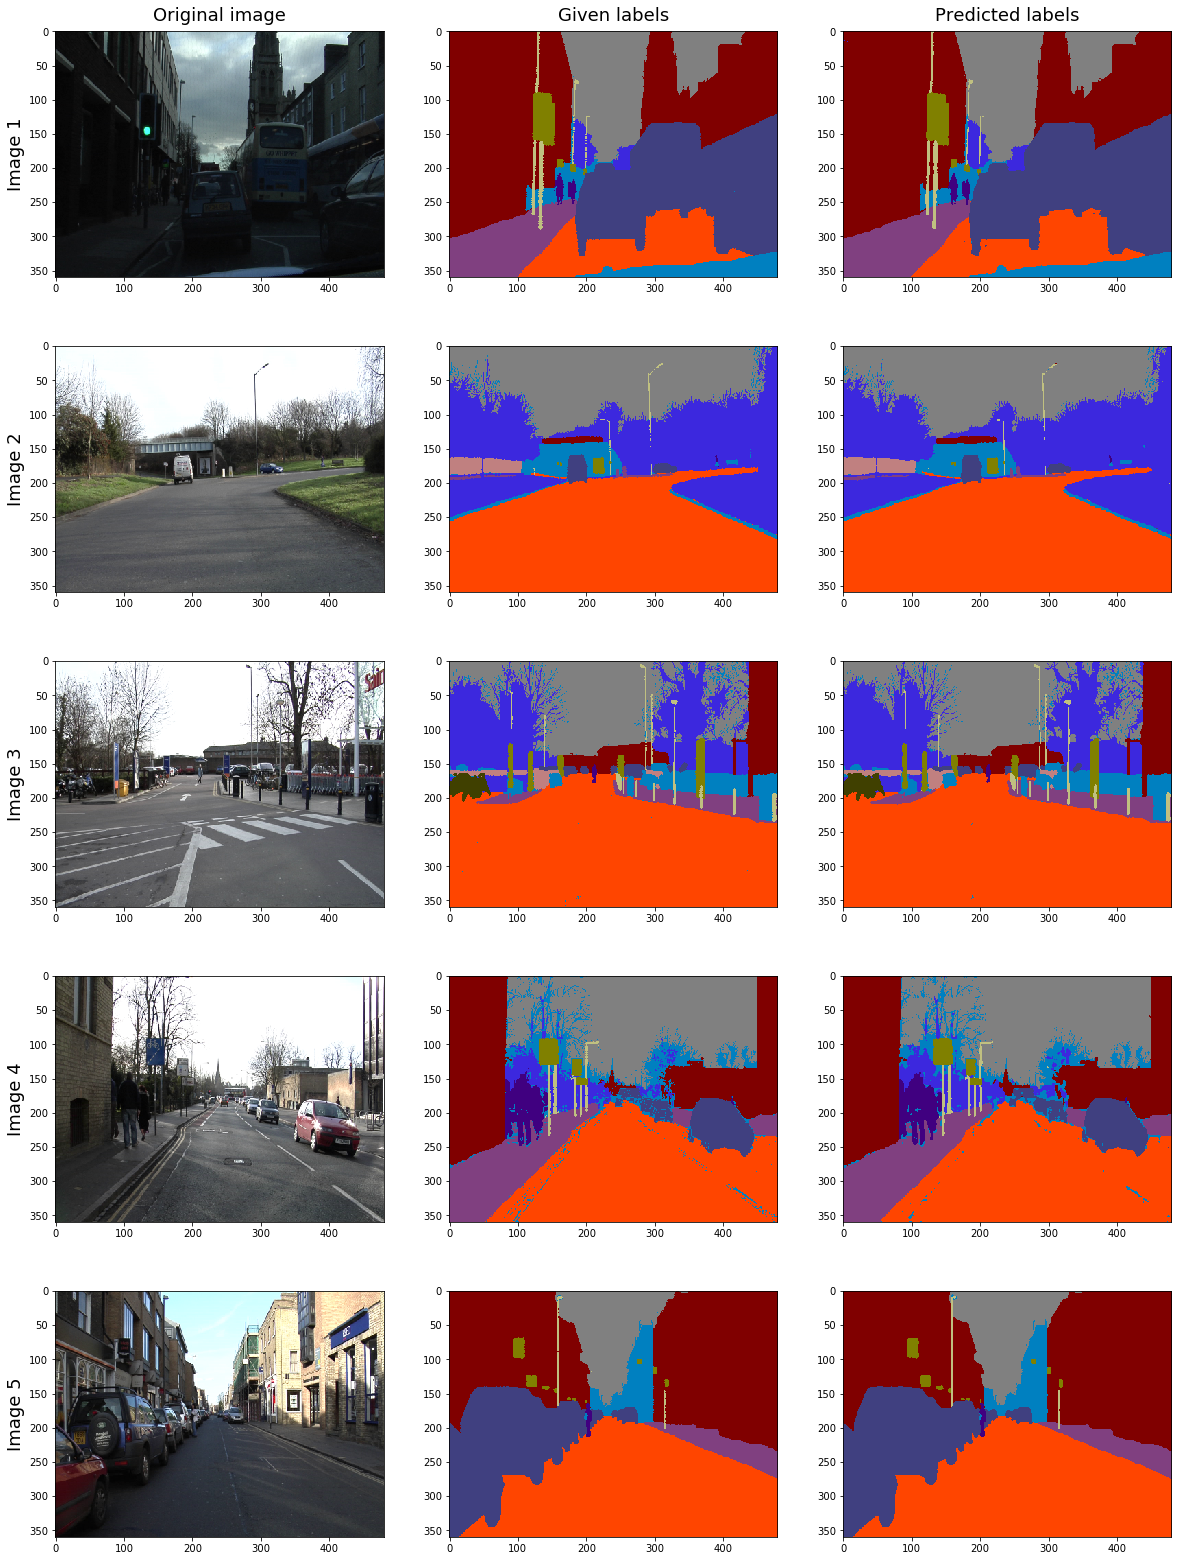

In [7]:
draw_plots(5, images, labels, predicted_labels)

# Validation

### Predictions

In [3]:
acc, pred, var = Test('Validation')

predicted_labels = []
for p in pred:
    predicted_labels.append(np.array(p).reshape([360,480]))

INFO:tensorflow:Restoring parameters from ./segnet_scratch/segnet_scratch_30000/model.ckpt-30000
101 CamVid test images are loaded
Image Index 0: TEST Loss 0.812, TEST Accu  0.889
accuracy = 0.888565
mean IU  = 0.494878
    class # 0 accuracy = 0.948894 
    class # 1 accuracy = 0.943548 
    class # 2 accuracy = 0.000000 
    class # 3 accuracy = 0.991032 
    class # 4 accuracy = 0.693221 
    class # 5 accuracy = 0.853133 
    class # 6 accuracy = 0.357542 
    class # 7 accuracy = 0.152620 
    class # 8 accuracy = 0.946977 
    class # 9 accuracy = 0.195175 
    class # 10 accuracy = 0.610794 
    class # 11 accuracy = 0.481591 
Image Index 1: TEST Loss 0.504, TEST Accu  0.920
accuracy = 0.919676
mean IU  = 0.549019
    class # 0 accuracy = 0.985272 
    class # 1 accuracy = 0.946079 
    class # 2 accuracy = 0.009511 
    class # 3 accuracy = 0.989198 
    class # 4 accuracy = 0.980072 
    class # 5 accuracy = 0.951431 
    class # 6 accuracy = 0.122434 
    class # 7 accuracy =

### Original images

In [4]:
image_filename,label_filename = get_filename_list(config["VAL_FILE"])
images, labels = get_all_test_data(image_filename,label_filename)
# Subset
indexes = [0,25,50,75,100]
images = [images[i] for i in range(len(images)) if i in indexes]
labels = [labels[i] for i in range(len(labels)) if i in indexes]

101 CamVid test images are loaded


### Plots

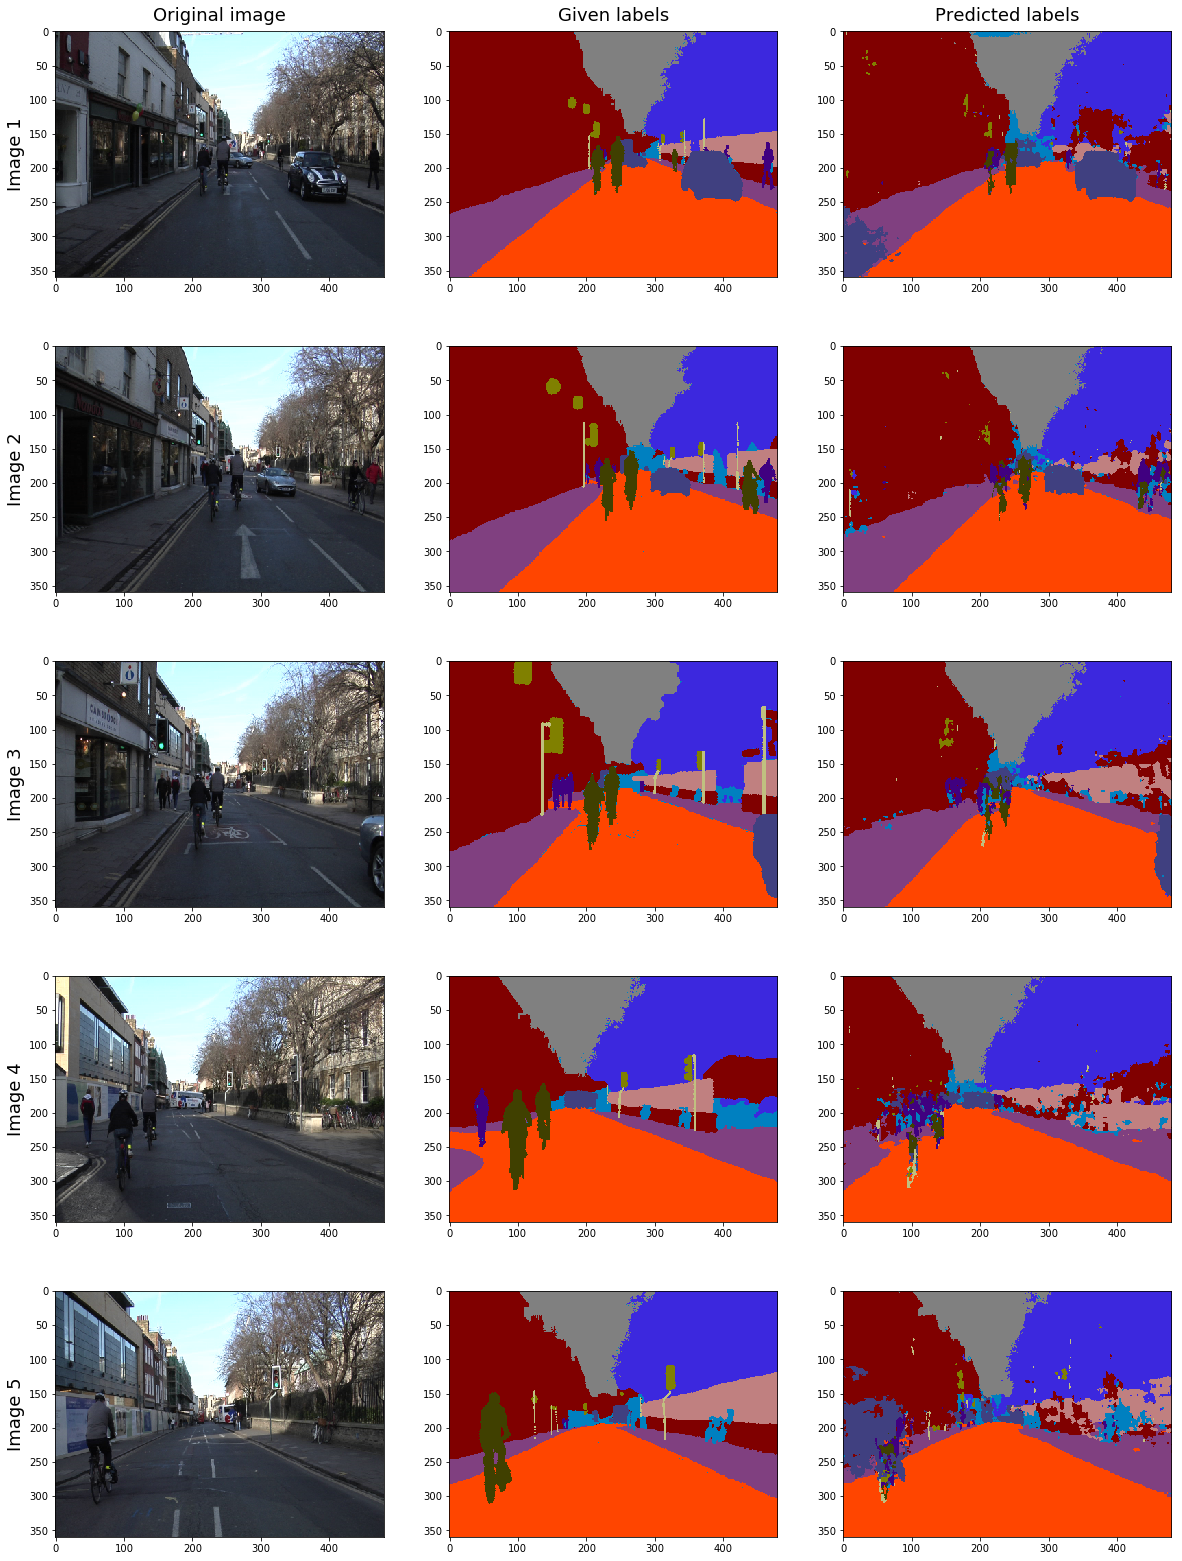

In [10]:
draw_plots(5, images, labels, predicted_labels)

# Test

### Predictions

In [3]:
acc, pred, var = Test('Test')

predicted_labels = []
for p in pred:
    predicted_labels.append(np.array(p).reshape([360,480]))

INFO:tensorflow:Restoring parameters from ./segnet_scratch/segnet_scratch_30000/model.ckpt-30000
233 CamVid test images are loaded
Image Index 0: TEST Loss 0.648, TEST Accu  0.907
accuracy = 0.906759
mean IU  = 0.545584
    class # 0 accuracy = 0.953268 
    class # 1 accuracy = 0.958952 
    class # 2 accuracy = 0.089910 
    class # 3 accuracy = 0.981495 
    class # 4 accuracy = 0.853161 
    class # 5 accuracy = 0.850890 
    class # 6 accuracy = 0.060591 
    class # 7 accuracy = 0.000000 
    class # 8 accuracy = 0.894750 
    class # 9 accuracy = 0.238579 
    class # 10 accuracy = 0.679808 
    class # 11 accuracy = 0.719307 
Image Index 1: TEST Loss 1.627, TEST Accu  0.788
accuracy = 0.788362
mean IU  = 0.411473
    class # 0 accuracy = 0.986498 
    class # 1 accuracy = 0.681720 
    class # 2 accuracy = 0.000000 
    class # 3 accuracy = 0.983677 
    class # 4 accuracy = 0.620948 
    class # 5 accuracy = 0.742583 
    class # 6 accuracy = 0.000000 
    class # 7 accuracy =

C:\Users\nebol\Documents\SegNet 2017-11-26\evaluation.py:101: RuntimeWarning: invalid value encountered in true_divide
  iu = np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist))


Image Index 2: TEST Loss 1.800, TEST Accu  0.764
accuracy = 0.763785
mean IU  = 0.323244
    class # 0 accuracy = 0.918732 
    class # 1 accuracy = 0.795562 
    class # 2 accuracy = 0.074421 
    class # 3 accuracy = 0.986938 
    class # 4 accuracy = 0.796394 
    class # 5 accuracy = 0.439878 
    class # 6 accuracy = 0.062286 
    class # 7 accuracy = 0.000000 
    class # 8 accuracy = 0.478102 
    class # 9 accuracy = 0.165906 
    class # 10 accuracy = 0.195757 
    class # 11 accuracy = 0.269802 
Image Index 3: TEST Loss 1.520, TEST Accu  0.796
accuracy = 0.795793
mean IU  = 0.363704
    class # 0 accuracy = 0.783715 
    class # 1 accuracy = 0.884981 
    class # 2 accuracy = 0.154229 
    class # 3 accuracy = 0.977293 
    class # 4 accuracy = 0.484266 
    class # 5 accuracy = 0.839315 
    class # 6 accuracy = 0.388027 
    class # 7 accuracy = 0.000000 
    class # 8 accuracy = 0.921325 
    class # 9 accuracy = 0.138952 
    class # 10 accuracy = 0.000000 
    class # 11

### Original images

In [4]:
test_path = "SegNet/CamVid/test.txt"
image_filename,label_filename = get_filename_list(test_path)
images, labels = get_all_test_data(image_filename,label_filename)
# Subset
indexes = [0,50,100,150,200]
images = [images[i] for i in range(len(images)) if i in indexes]
labels = [labels[i] for i in range(len(labels)) if i in indexes]

233 CamVid test images are loaded


### Plots

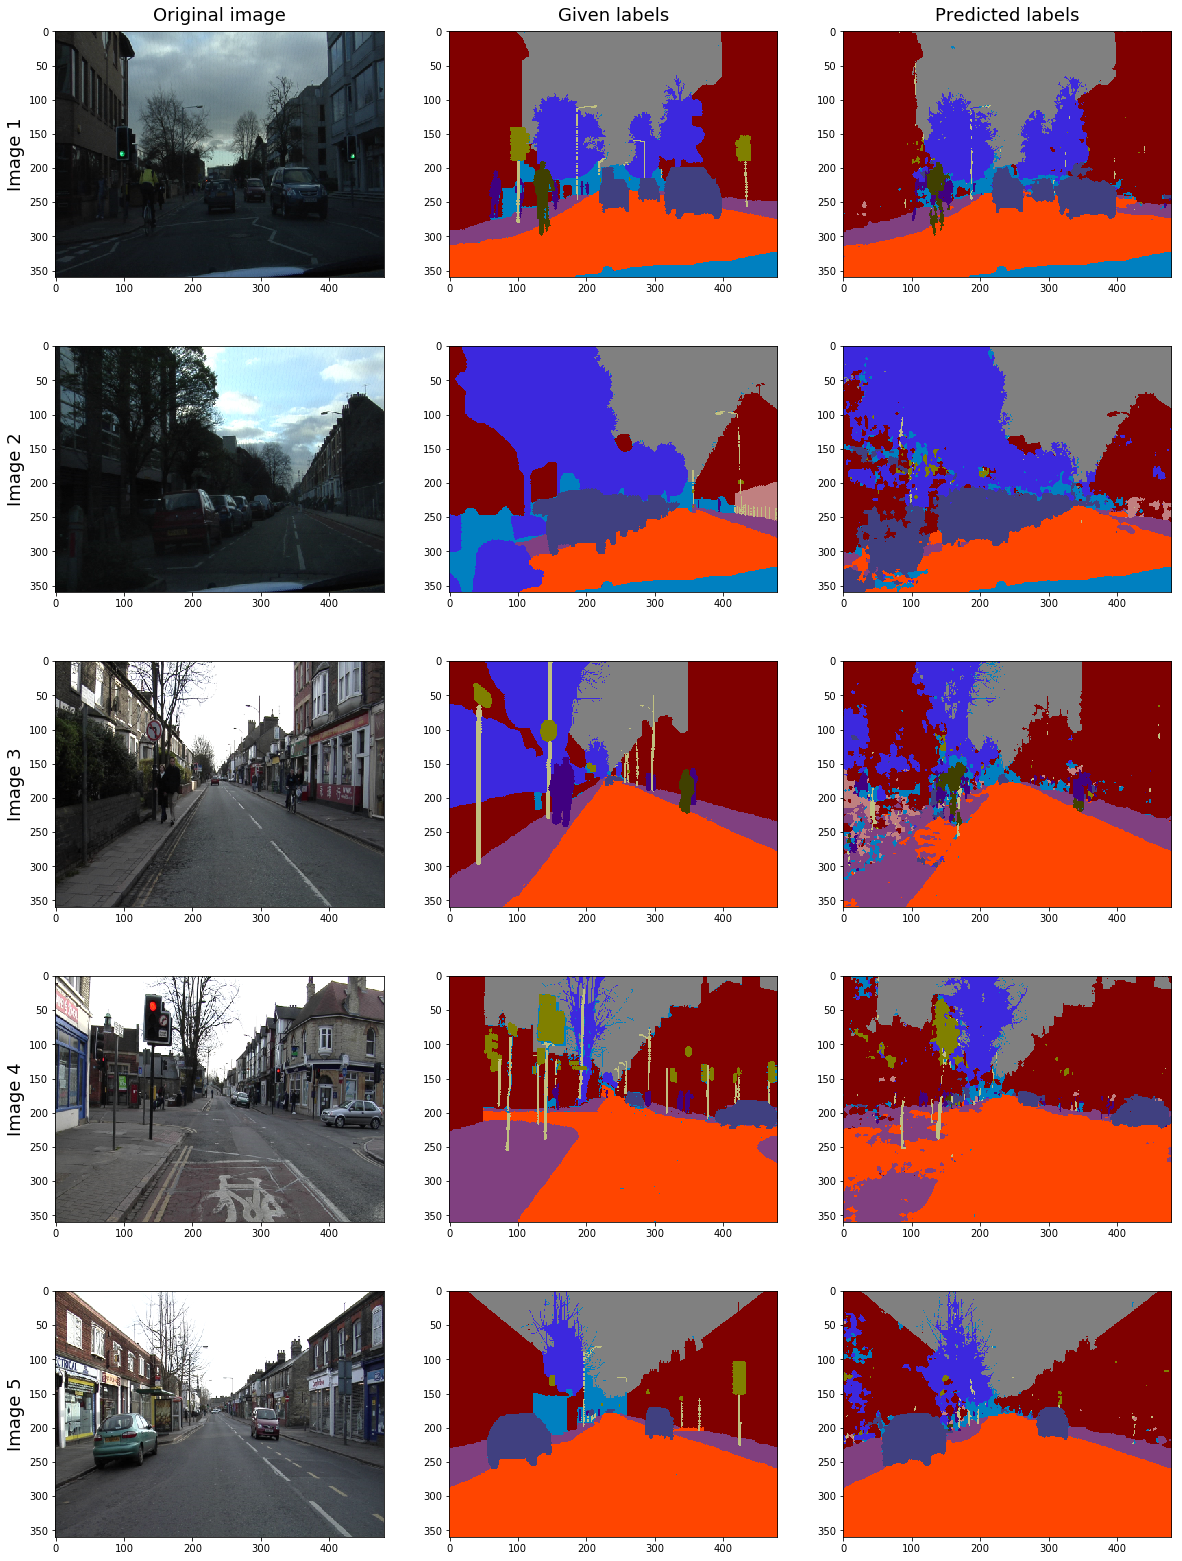

In [8]:
draw_plots(5, images, labels, predicted_labels)